In [1]:
import astropy
from astropy.io import fits
from math import pi, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, scatter, show
from time import time
import numpy as np
import pandas as pd
import os
from map_cylindric import get_header_params_MDI, map_disk_cylindric
#import seaborn as sns turns images from color to black & white
%matplotlib inline

In [2]:
import hdbscan

In [3]:
import astropy.convolution
from astropy.convolution import convolve_fft, convolve

In [4]:
def preprocess_image(hdu_object):
    # upload data to dataframe in order to replace nans with zeros
    df = pd.DataFrame(hdu_object.data)
    df.fillna(value=0,inplace=True)
    clean_data = df.values
    # extract parameters from header  
    xCen,yCen,s0,nx,pixsize,p0,b0, r0 = get_header_params_MDI(hdu_object.header)
    # transform data into cylindrical equal area map
    return map_disk_cylindric(xCen,yCen,s0,nx,pixsize,p0,b0, r0, clean_data)

###Import and Process Image

In [5]:
path = "/Users/Alexander/NASA/NASA_Sample_Data/fd_M_96m_01d.6543.0000.fits"
hdulist = fits.open(path)
hdu = hdulist[0]
clean_data = preprocess_image(hdu)

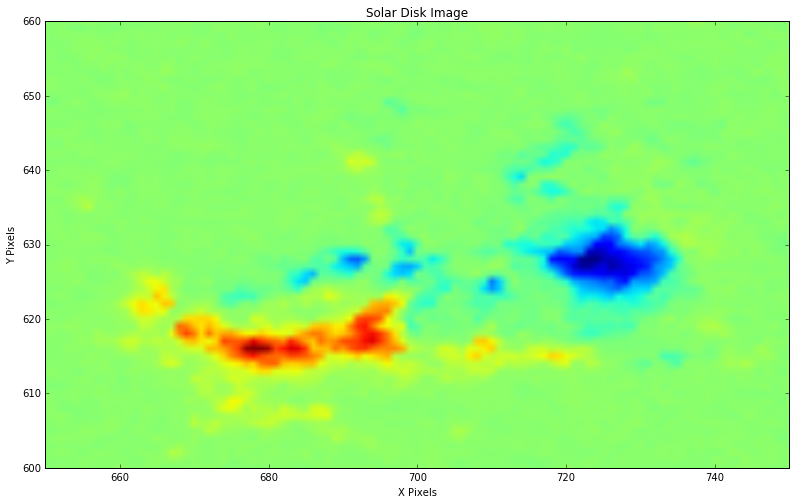

In [8]:
plt.figure(figsize = (15,8));
a1 = np.ma.masked_where(clean_data == 0.0, clean_data)
plt.imshow(a1, origin='lower');
plt.title("Solar Disk Image")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.xlim((650,750))
plt.ylim((600,660))
#plt.colorbar()
plt.show()

In [9]:
data_abs = np.abs(clean_data)

In [10]:
gauss = astropy.convolution.Gaussian2DKernel(stddev=3)

In [11]:
start = time()
smoothing_one = convolve_fft(data_abs, gauss)
smoothing_two = convolve_fft(smoothing_one,gauss)
end = time()
print "Time Elapsed {:.3}".format(end - start)

Time Elapsed 2.46


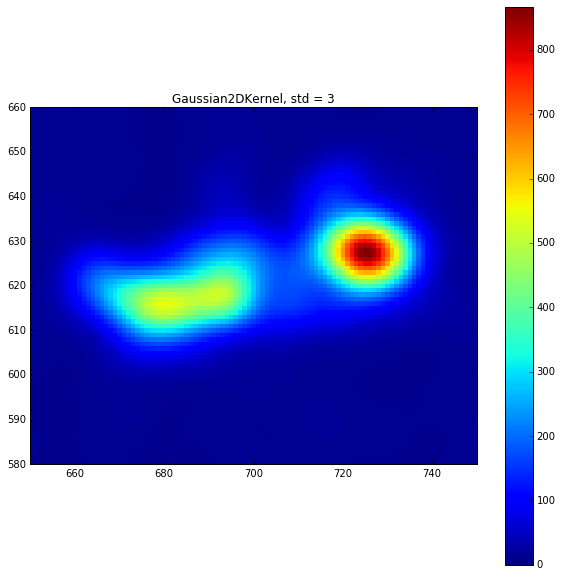

In [12]:
plt.figure(figsize = (10,10));
plt.imshow(smoothing_two, interpolation='none', origin='lower');
plt.title("Gaussian2DKernel, std = 3")
plt.xlim((650,750))
plt.ylim((580,660))
plt.colorbar()
plt.show()

###Challenge: Need to find automated way to choose threshold parameter, k

In [13]:
k = 300
smoothing_two[smoothing_two < k] = 0.
smoothing_two[smoothing_two >= k] = 1 

In [28]:
# filter original image with active region map 
test = np.where(smoothing_two !=0.0 , clean_data, smoothing_two)

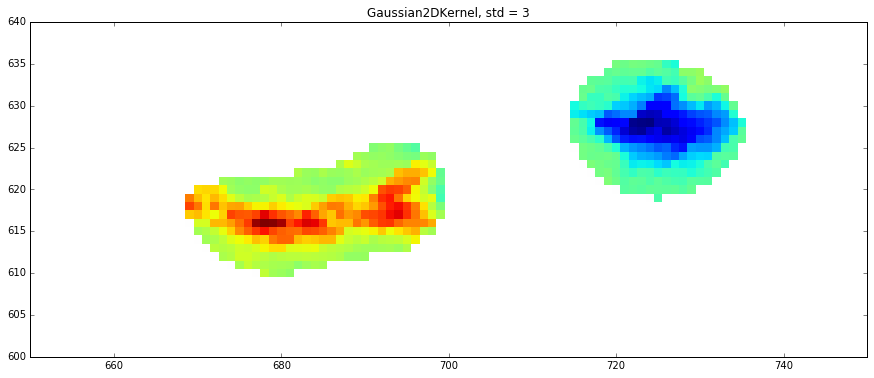

In [29]:
plt.figure(figsize = (15,15));
test_plot  = np.ma.masked_where(test == 0.0, test)
plt.imshow(test_plot, interpolation='none', origin='lower');
plt.title("Gaussian2DKernel, std = 3")
#plt.colorbar()
plt.xlim((650,750))
plt.ylim((600,640))
plt.show()

###Clustering

Model needs to be tuned to 'see' that there are 2 sunspots clusters, not 3. 
By looking at the contour maps, we see that there are 3 highly dense regions, 
this must be what hdbscan sees as the 3 clusters -- though we want it to find 2 clusters. 

Potential Solutions: maybe we can help the model 'see' the polarity of the field,
this may help to distinguish distinct sunspots (i.e. even though there are 2 highly dense regions near each other, if they have the same polarity, then they are a single sunspot, and not 2)

##Clustering Results on Image with Noise

In [89]:
model = hdbscan.HDBSCAN(min_cluster_size=50, 
                        min_samples=20, 
                        gen_min_span_tree=True)

In [90]:
# active map filtered data
hdb_result = model.fit_predict(clean_data)

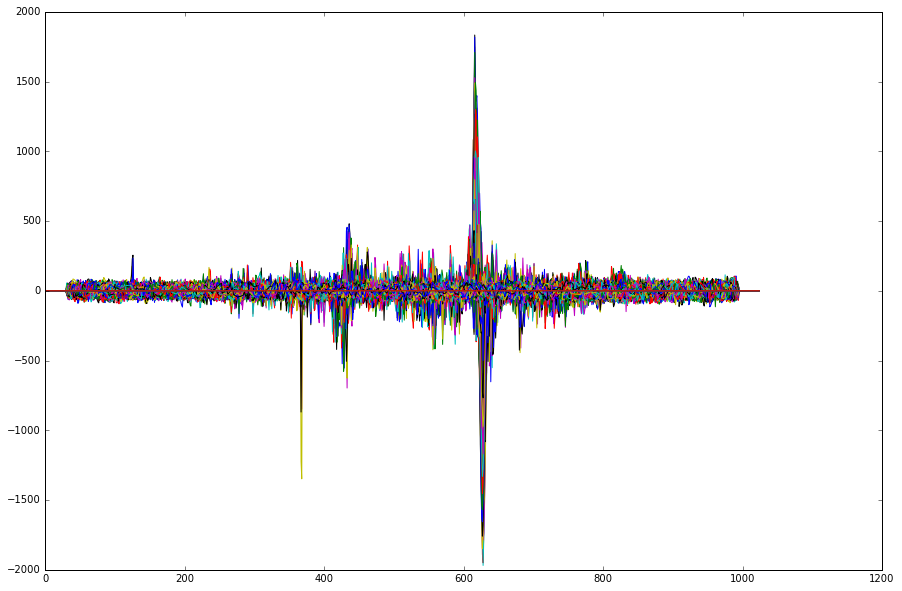

In [91]:
plt.figure(figsize = (15,10));
plt.plot(clean_data);

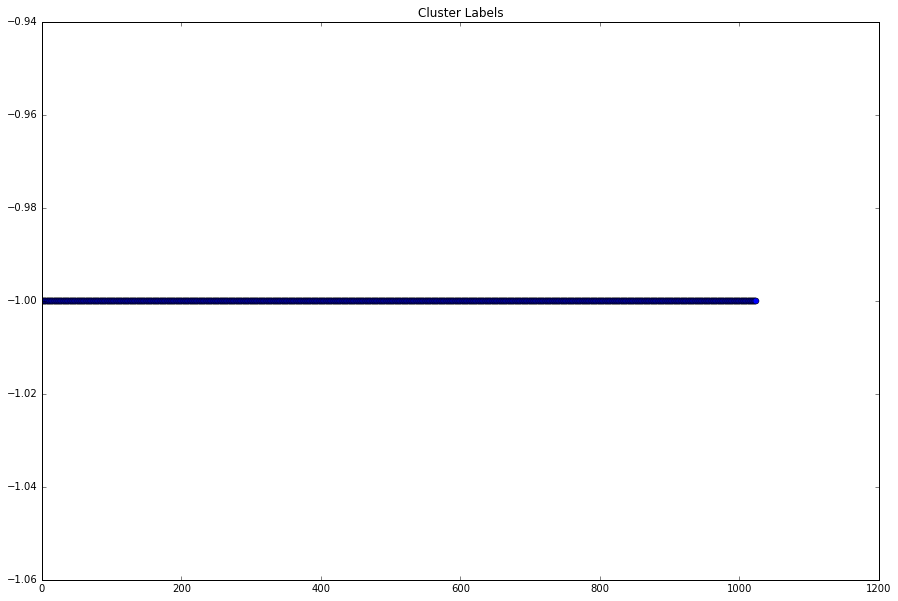

In [105]:
# recall, noise is given the label "-1"
plt.figure(figsize = (15,10));
plt.title("Cluster Labels");
plt.plot( hdb_result,'bo');

##Clustering Results on Image without Noise

In [93]:
model_ = hdbscan.HDBSCAN(min_cluster_size=50, 
                        min_samples=20, 
                        gen_min_span_tree=True)

In [94]:
# active map filtered data
hdb_result_ = model_.fit_predict(test)

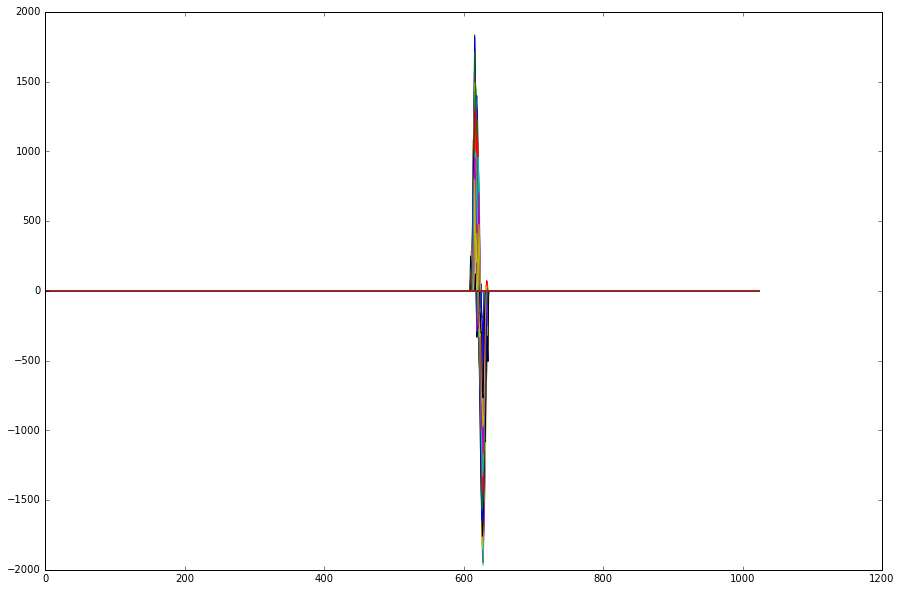

In [103]:
plt.figure(figsize = (15,10));
plt.plot(test);

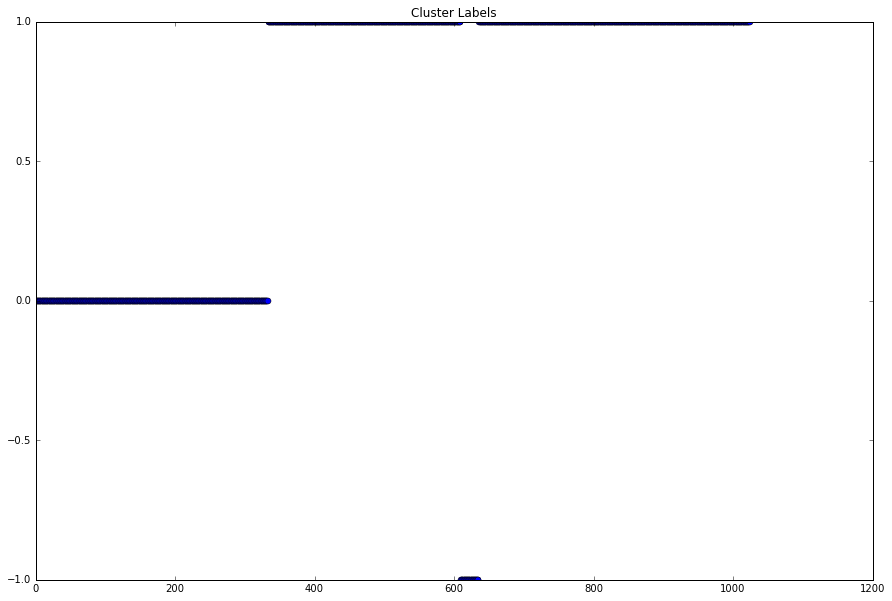

In [106]:
# recall, noise is given the label "-1"
plt.figure(figsize = (15,10));
plt.title("Cluster Labels");
#plt.xlim((350,450))
#plt.ylim((-0.1,0.1))
plt.plot( hdb_result_,'bo');

##Results
HDBSCAN has it backwards: it has labeled signal as noise and labled noise as signal. Compare the above two graphs, the "-1" label as been assgined the the region containing the two peaks. Also, it has sub-divided what it considers signal (though it's actually noise).

HDBSCAN is performing very poorly.I have ran HDBSCAN on the pre-FFT image and the post-FFT image. They both preduce grossly incorrect results. Perhaps, the images should be preprocess differently. However, it seems that the transformed data from the Fast Fourier Transform strikes me as the cleanest form we can hope to achieve. 

In [34]:
path = "/Users/Alexander/NASA/NASA_Sample_Data/Images/"
filelist = []
for i, filename in enumerate(os.listdir(path)):
    if i != 0:
        filelist.append(filename)

In [35]:
hdulist = fits.open(path + filelist[200])
hdu = hdulist[0]
clean_data_diff = preprocess_image(hdu)

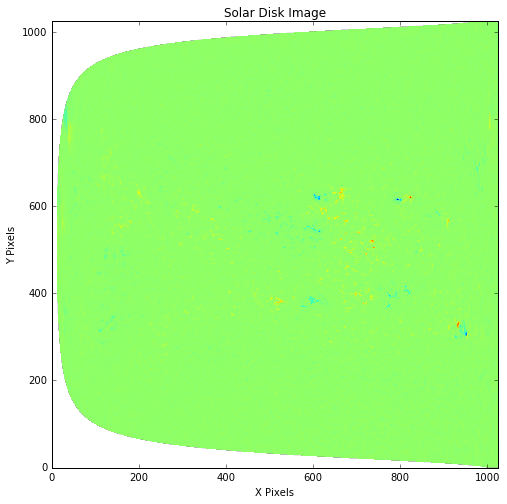

In [36]:
plt.figure(figsize = (15,8));
a1 = np.ma.masked_where(clean_data_diff == 0.0, clean_data_diff)
plt.imshow(a1, origin='lower');
plt.title("Solar Disk Image")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
# plt.xlim((280,380))
#plt.ylim((200,600))
#plt.colorbar()

plt.show()

In [37]:
data_abs_diff = np.abs(clean_data_diff)

In [38]:
start = time()
smoothing_one_diff = convolve_fft(data_abs_diff, gauss)
smoothing_two_diff = convolve_fft(smoothing_one_diff,gauss)
end = time()
print "Time Elapsed {:.3}".format(end - start)

Time Elapsed 2.67


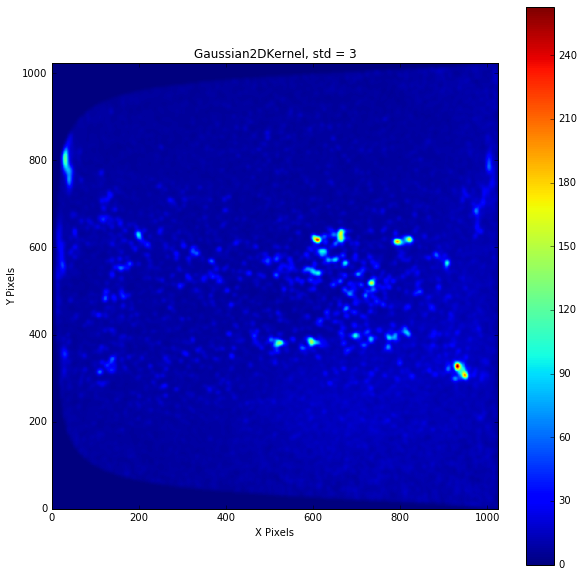

In [39]:
plt.figure(figsize = (10,10));
plt.imshow(smoothing_two_diff, interpolation='none', origin='lower');
plt.title("Gaussian2DKernel, std = 3")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
# plt.xlim((650,750))
# plt.ylim((580,660))
plt.colorbar()
plt.show()

In [40]:
k = 150
smoothing_two_diff[smoothing_two_diff < k] = 0.
smoothing_two_diff[smoothing_two_diff >= k] = 1 

In [41]:
# filter original image with active region map 
test_diff = np.where(smoothing_two_diff !=0.0 , clean_data_diff, smoothing_two_diff)

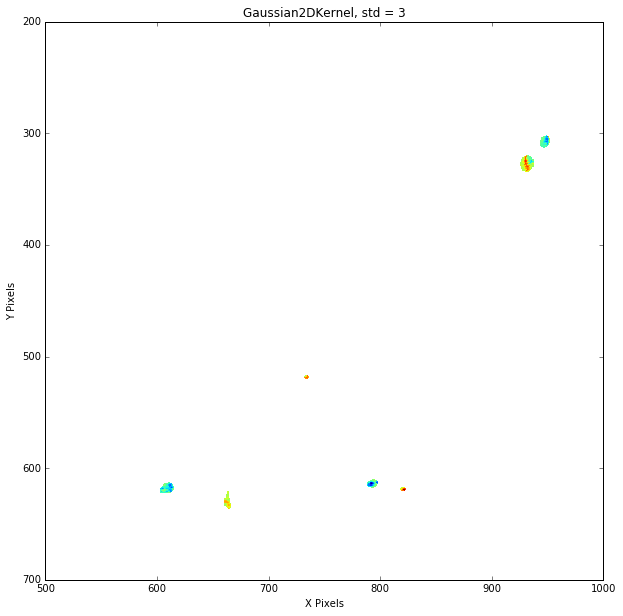

In [45]:
plt.figure(figsize = (10,10));
test_plot_diff  = np.ma.masked_where(test_diff == 0.0, test_diff)
plt.imshow(test_plot_diff, interpolation='none', origin='lower');
plt.title("Gaussian2DKernel, std = 3")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
#plt.colorbar()
plt.xlim((500,1000))
plt.ylim((700,200))
plt.show()

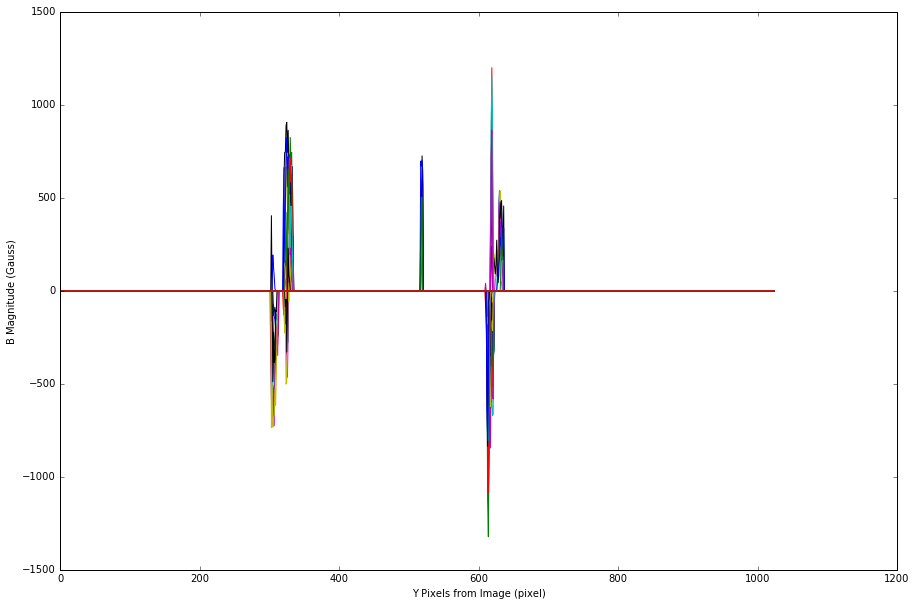

In [61]:
plt.figure(figsize = (15,10));
#plt.xlim([250,650])
#plt.ylim([-1000,1000])
plt.xlabel("Y Pixels from Image (pixel)")
plt.ylabel("B Magnitude (Gauss)")
plt.plot(test_diff);

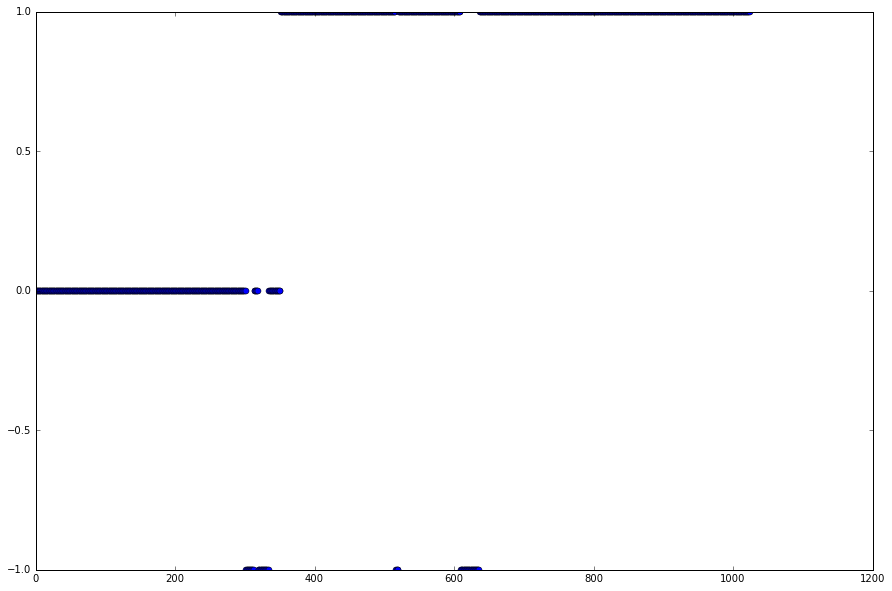

In [60]:
plt.figure(figsize = (15,10));
plt.plot(fit_pred,'bo');

In [50]:
model2 = hdbscan.HDBSCAN(min_cluster_size=15, 
                        min_samples=40, 
                        gen_min_span_tree=True)

In [51]:
results2 = model2.fit(test_diff)

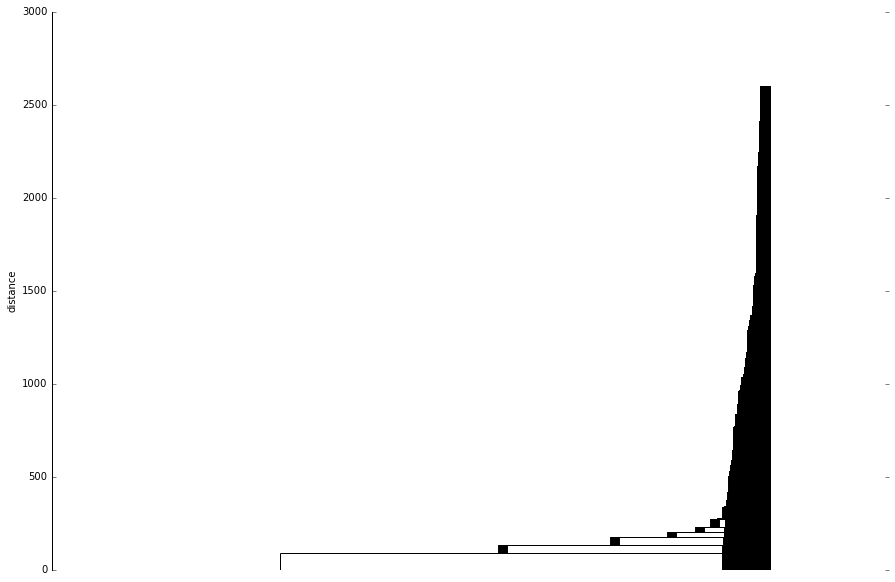

In [52]:
plt.figure(figsize = (15,10));
results2.single_linkage_tree_.plot();

In [53]:
np.unique( results2.labels_)

array([-1,  0,  1])

In [55]:
fit_pred = model2.fit_predict(test_diff)

In [56]:
fit_pred.shape

(1025,)

In [57]:
fit_pred

array([0, 0, 0, ..., 1, 1, 1])